<a href="https://colab.research.google.com/github/VHKA1729/air-pollution/blob/master/vhka1.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<font size="20"><h3 align='center'>**_DSL Project_**</font><br>
    
    
<font size="5"><h3 align='center'><span style='color:Blue'> Predict impact of air quality on mortality rates(Kaggle Competition)</font>


<font size="3"><h3 align='center'>https://www.kaggle.com/c/predict-impact-of-air-quality-on-death-rates/overview</font><br>
    <br>


<font size="3">**Group Number - 2**<br>
<font size="3"> Mimansi Agarwal   &emsp;19BM6JP15</font>        
<font size="3"> Vaibhav HK Anand  &emsp;19BM6JP24</font>    
<font size="3"> Bankar Prasad Vilas &emsp;19BM6JP25</font> 


## TO DO

- ANOVA on variables per region
- XGB Regressor
- Best depth via cost pruning for RFR
- Graphs for regulartization 

# Libraries

In [0]:
#!pip install impyute

In [0]:
SEED = 1729

In [0]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from impyute.imputation.cs import mice
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import  make_scorer, mean_absolute_error, r2_score, median_absolute_error, mean_squared_error
import math

import missingno as msno

import plotly.express as px
import plotly.graph_objects as go

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

import gc
import random
import os

import scipy.stats as sps 

In [0]:
#plt.style.available

In [0]:
plt.style.use('fivethirtyeight')

# Functions

In [0]:
def seed_everything(SEED=1729):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    print('done')

seed_everything()

In [0]:
def f(x):
  if (x<=0):
    return(np.nan)
  else:
    return(x)

In [0]:
def reduce_mem_usage(df, verbose=True):
    '''
    Reduces the usage of memory by a dataframe
    '''
    start_mem = df.memory_usage().sum() / 2**20
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] #defining a list of numeric types
    #start_mem = df.memory_usage().sum() / 2**20   #converting bytes into MB
    for col in df.columns: # iterating over each column of dataframe
        col_type = df[col].dtypes # extracting the data type of a single column
        if col_type in numerics: # checking whether the data type of column is a numeric datatype or not
            c_min = df[col].min()
            c_max = df[col].max()
          
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype('float16')
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype('float32')
            else:
                df[col] = df[col].astype('float64')    
    end_mem = df.memory_usage().sum() / 2**20
    if verbose: print('Mem. usage decreased to {:5.5f} Mb ({:.2f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
def reg_metrics (y_true,y_predicted):
  mse = mean_squared_error(y_true,y_predicted)
  print("MSE = " + str(mse))
  print("RMSE =" + str(math.sqrt(mse)))
  print("Mean Absolute Error =" + str(mean_absolute_error(y_true,y_predicted)))
  print('Median Absolute Error  = ' + str(median_absolute_error(y_true, y_predicted)))
  print('R^2                    = ' + str(r2_score(y_true, y_predicted)))
  del mse
  gc.collect()

In [0]:
def resid_plot(y_true, y_predicted):
    '''
    1. Plots residual plots by taking the y_true and y_predicted as input.
    2. Can be used with any regression method be it linear, ridge, lasso, boosting-based, etc.
    '''
    temp1 = np.array(y_true).reshape(-1,1)
    temp2 = np.array(y_predicted).reshape(-1,1)

    resids = np.subtract(temp1,temp2) #calculating residuals

    sns.regplot(x=y_predicted, y=resids, fit_reg=True)

    plt.title("Residuals vs. Predicted Values")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")

    plt.show()
    plt.close()
    del temp1, temp2
    gc.collect()

In [0]:
def resids_hist(y_true,y_predicted):
  '''
  Plots histogram of residuals
  '''

  temp1 = np.array(y_true).reshape(-1,1)
  temp2 = np.array(y_predicted).reshape(-1,1)

  resids = np.subtract(temp1,temp2) 

  sns.distplot(resids)

  plt.title("Histogram of Residual Values")
  plt.xlabel("Residuals")
  plt.ylabel("Count")
  del temp1, temp2
  gc.collect()

In [0]:
def resid_qq(y_true, y_predicted):
    resids = np.subtract(np.array(y_true).reshape(-1,1),  np.array(y_predicted).reshape(-1,1))
    sps.probplot(resids.flatten(), plot = plt)
    plt.title('Q-Q Plot of residuals')
    plt.xlabel('Quantiles of standard Normal distribution')
    plt.ylabel('Quantiles of residuals')
    plt.show()

## Regularization

In [0]:
def plot_regularization(l, train_RMSE, test_RMSE, coefs, min_idx, title):   
    plt.plot(l, test_RMSE, color = 'green', label = 'Test RMSE')
    plt.plot(l, train_RMSE, label = 'Train RMSE')    
    plt.axvline(min_idx, color = 'black', linestyle = '--')
    plt.legend()
    plt.xlabel('Regularization parameter')
    plt.ylabel('Root Mean Square Error')
    plt.title(title)
    plt.show()
    
    plt.plot(l, coefs)
    plt.axvline(min_idx, color = 'black', linestyle = '--')
    plt.title('Model coefficient values \n vs. regularizaton parameter')
    plt.xlabel('Regularization parameter')
    plt.ylabel('Model coefficient value')
    plt.show()

In [0]:
def test_regularization_l2(x_train, y_train, x_test, y_test, l2):
    train_RMSE = []
    test_RMSE = []
    coefs = []
    for reg in l2:
        lin_mod = Ridge(alpha = reg)
        lin_mod.fit(x_train, y_train)
        coefs.append(lin_mod.coef_)
        y_score_train = lin_mod.predict(x_train)
        train_RMSE.append(mean_squared_error(y_train, y_score_train)**0.5)
        y_score = lin_mod.predict(x_test)
        test_RMSE.append(mean_squared_error(y_test, y_score)**0.5)
    min_idx = np.argmin(test_RMSE)
    min_l2 = l2[min_idx]
    min_RMSE = test_RMSE[min_idx] 
    
    title = 'Train and test root mean square error \n vs. regularization parameter'
    plot_regularization(l2, train_RMSE, test_RMSE, coefs, min_l2, title)
    return min_l2, min_RMSE

In [0]:
def ridge(X_train,y_train, X_test, y_test):
  l2 = [x for x in range(0,50)]
  out_l2 = test_regularization_l2(X_train, y_train, X_test, y_test, l2)
  print(out_l2)
  lin_mod_l2 = Ridge(alpha = out_l2[0])
  lin_mod_l2.fit(X_train, y_train)
  y_score_l2 = lin_mod_l2.predict(X_test)
  print()
  reg_metrics(y_test, y_score_l2)
  resids_hist(np.array(y_test), np.array(y_score_l2))  
  resid_qq(np.array(y_test), np.array(y_score_l2)) 
  resid_plot(np.array(y_test), np.array(y_score_l2))

In [0]:
def test_regularization_l1(x_train, y_train, x_test, y_test, l1):
    train_RMSE = []
    test_RMSE = []
    coefs = []
    for reg in l1:
        lin_mod = Lasso(alpha = reg)
        lin_mod.fit(x_train, y_train)
        coefs.append(lin_mod.coef_)
        y_score_train = lin_mod.predict(x_train)
        train_RMSE.append(mean_squared_error(y_train, y_score_train)**0.5)
        y_score = lin_mod.predict(x_test)
        test_RMSE.append(mean_squared_error(y_test, y_score)**0.5)
    min_idx = np.argmin(test_RMSE)
    min_l1 = l1[min_idx]
    min_RMSE = test_RMSE[min_idx]
    
    title = 'Train and test root mean square error \n vs. regularization parameter'
    plot_regularization(l1, train_RMSE, test_RMSE, coefs, min_l1, title)
    return min_l1, min_RMSE

In [0]:
def lasso(X_train,y_train,X_test,y_test):
    l1 = [x/5000 for x in range(1,50)]
    out_l1 = test_regularization_l1(X_train, y_train, X_test, y_test, l1)
    print(out_l1)
    lin_mod_l1 = Lasso(alpha = out_l1[0])
    lin_mod_l1.fit(X_train, y_train)
    y_score_l1 = lin_mod_l1.predict(X_test)
    print()
    reg_metrics(y_test, y_score_l1) 
    resids_hist(np.array(y_test), np.array(y_score_l1))
    resid_qq(np.array(y_test), np.array(y_score_l1)) 
    resid_plot(np.array(y_test), np.array(y_score_l1))

# Data import

In [0]:
train = pd.read_csv('/content/train.csv', parse_dates=['date'], index_col='Id')
test = pd.read_csv('/content/test.csv', parse_dates=['date'], index_col='Id')
region=pd.read_csv('/content/regions.csv')

In [0]:
train.head()

# Exploratory data analysis

In [0]:
region

In [0]:
# Checking that the date column is monotonic
for r in train['region'].unique():
  print(train[train['region']==r]['date'].is_monotonic)
del r

In [0]:
train.info()

In [0]:
train.describe()

In [0]:
test.info()

In [0]:
test.describe()

In [0]:
region.info()

## Missing Values

In [0]:
train.isna().sum()

In [0]:
msno.bar(train)

In [0]:
msno.bar(test)

# No missing values

In [0]:
temp = train.set_index('date')

for r in train['region'].unique():
  t = temp[temp['region']==r]
  print(msno.matrix(t, freq = 'A'))

del temp, t
gc.collect()

In [0]:
msno.heatmap(train)

# https://github.com/ResidentMario/missingno

# correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another
# Variables that are always full or always empty have no meaningful correlation, and so are silently removed from the visualization—in this case for instance the datetime and injury number columns, which are completely filled, are not included.

In [0]:
for r in train['region'].unique():
  t = train[train['region']==r]
  print(msno.heatmap(t))

del t
gc.collect()

In [0]:
msno.dendrogram(train)

In [0]:
for r in train['region'].unique():
  t = train[train['region']==r]
  print(msno.dendrogram(t))

del t
gc.collect()

**_Missing values present in 4 columns, O3 ,PM10, PM25, NO2_**

## Merging Region names with the rest of the data

In [0]:
train1 = train.merge(region, left_on='region', right_on='Code')
#train1.drop(columns = ['region'],inplace=True)
test1 = test.merge(region, left_on='region', right_on='Code')
#test1.drop(columns = ['region'],inplace=True)

## univariate analysis ##

In [0]:
# Visualizing mortality_rate
def mr(df):
  plt.subplot(121)
  sns.distplot(df['mortality_rate']);

  plt.subplot(122)
  df['mortality_rate'].plot.box(figsize=(16,5))

  plt.show()

mr(train)

In [0]:
# Visualizing O3
def o3(df):
    plt.subplot(121)
    O3_1 = train['O3'].dropna()
    sns.distplot(O3_1);

    plt.subplot(122)
    O3_1.plot.box(figsize=(16,5))

    plt.show()
    plt.close()

o3(train)

In [0]:
# Visualizing PM10
def pm10(df):
    plt.subplot(121)
    PM10_1 = train['PM10'].dropna()
    sns.distplot(PM10_1);

    plt.subplot(122)
    PM10_1.plot.box(figsize=(16,5))

    plt.show()

pm10(train)

In [0]:
# Visualizing PM25

def pm25(df):
    plt.subplot(121)
    PM25_1 = train['PM25'].dropna()
    sns.distplot(PM25_1);

    plt.subplot(122)
    PM25_1.plot.box(figsize=(16,5))

    plt.show()

pm25(train)

In [0]:
# Visualizing NO2
def no2(df):
    plt.subplot(121)
    NO2_1 = train['NO2'].dropna()
    sns.distplot(NO2_1);

    plt.subplot(122)
    NO2_1.plot.box(figsize=(16,5))

    plt.show()
  
no2(train)

In [0]:
# Visualizing T2M

def t2m(df):
    plt.subplot(121)
    sns.distplot(train['T2M']);

    plt.subplot(122)
    train['T2M'].plot.box(figsize=(16,5))

    plt.show()

t2m(train)

In [0]:
# Visualizing categorical features
plt.subplot(231)
train['region'].value_counts(normalize=True).plot.bar(figsize=(20,10), title= 'region')

In [0]:
print('mortality rate across regions')
for r in train['region'].unique():
  t = train[train['region']==r]
  mr(t)

In [0]:
print('ozone across regions')
for r in train['region'].unique():
  t = train[train['region']==r]
  o3(t)

In [0]:
for r in train['region'].unique():
  t = train[train['region']==r]
  no2(t)

In [0]:
for r in train['region'].unique():
  t = train[train['region']==r]
  pm10(t)
plt.close()

In [0]:
for r in train['region'].unique():
  t = train[train['region']==r]
  pm25(t)
plt.close()

In [0]:
for r in train['region'].unique():
  t = train[train['region']==r]
  t2m(t)
plt.close()

In [0]:
#train1.groupby("region")["Region"].unique()

In [0]:
train1.head()

## Transformations

# Bivariate analysis - Region Wise

### variation with date - time series plot ##

### For region 1 - North East

In [0]:
train_r1 = train1[train1["Region"]=="North East"]
fig1 = px.line(train_r1, x='date', y='mortality_rate')
fig1.show()

In [0]:
fig2 = go.Figure([go.Scatter(x=train_r1['date'], y=train_r1['mortality_rate'])])
#fig2.show()

fig2.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)

In [0]:
fig3 = go.Figure([go.Scatter(x=train_r1['date'], y=train_r1["O3"])])
#fig2.show()

fig3.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)

In [0]:
fig2 = go.Figure([go.Scatter(x=train_r1['date'], y=train_r1["PM10"])])
#fig2.show()

fig2.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)

In [0]:
fig4 = go.Figure([go.Scatter(x=train_r1['date'], y=train_r1["PM25"])])
#fig2.show()

fig4.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)

In [0]:
fig5 = go.Figure([go.Scatter(x=train_r1['date'], y=train_r1["NO2"])])
#fig2.show()

fig5.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)

### scatter plot of PM25 with other variables ###

In [0]:
plt.scatter(x=train_r1['mortality_rate'], y=train_r1["PM25"])

In [0]:
plt.scatter(x=train_r1['PM10'], y=train_r1["PM25"])

In [0]:
plt.scatter(x=train_r1['O3'], y=train_r1["PM25"])

In [0]:
plt.scatter(x=train_r1['NO2'], y=train_r1["PM25"])

In [0]:
plt.scatter(x=train_r1['T2M'], y=train_r1["PM25"])

### scatter plot of NO2 with other variables ###

In [0]:
plt.scatter(x=train_r1['mortality_rate'], y=train_r1["NO2"])

In [0]:
plt.scatter(x=train_r1['O3'], y=train_r1["NO2"])

In [0]:
plt.scatter(x=train_r1['PM10'], y=train_r1["NO2"])

In [0]:
plt.scatter(x=train_r1['PM25'], y=train_r1["NO2"])

In [0]:
plt.scatter(x=train_r1['T2M'], y=train_r1["NO2"])

## Missing value imputation using MICE 

#### For Region1 - North East

In [0]:
train_r1.head()

In [0]:
train_r1.isna().sum()

In [0]:
train_r1.drop(columns=["region","date", "Code", "Region"], inplace=True)

In [0]:
# start the MICE training
train_r1_imp=mice(train_r1.values)

In [0]:
train_r1_imp = pd.DataFrame(train_r1_imp, columns = ["mortality_rate", "O3", "PM10", "PM25","NO2","T2M"])

In [0]:
train_r1_imp.isna().sum()

In [0]:
# Visualizing NO2
# plt.figure(1)
plt.subplot(121)
NO2_1 = train_r1_imp['NO2'].dropna()
sns.distplot(NO2_1);

plt.subplot(122)
NO2_1.plot.box(figsize=(16,5))

plt.show()


plt.subplot(121)
NO2_1 = train_r1['NO2'].dropna()
sns.distplot(NO2_1);

plt.subplot(122)
NO2_1.plot.box(figsize=(16,5))

plt.show()

In [0]:
plt.scatter(x=train_r1_imp['O3'], y=train_r1_imp["NO2"])
plt.scatter(x=train_r1['O3'], y=train_r1["NO2"])

In [0]:
plt.scatter(x=train_r1_imp['PM10'], y=train_r1_imp["NO2"])
plt.scatter(x=train_r1['PM10'], y=train_r1["NO2"])

In [0]:
# Visualizing NO2
# plt.figure(1)
plt.subplot(121)
NO2_1_imp = train_r1_imp['PM25'].dropna()
NO2_1 = train_r1['PM25'].dropna()
#sns.distplot(NO2_1_imp)
#sns.distplot(NO2_1)

sns.distplot(NO2_1_imp, hist=False, rug=True)
sns.distplot(NO2_1, hist=False, rug=True)


In [0]:
plt.scatter(x=train_r1_imp['PM10'], y=train_r1_imp["PM25"])
plt.scatter(x=train_r1['PM10'], y=train_r1["PM25"])

In [0]:
train_r1_imp['PM25'].describe(), train_r1['PM25'].describe()

In [0]:
train_r1_imp['NO2'].describe(), train_r1['NO2'].describe()

In [0]:
## changing negative values to min value
#train_r1_imp['PM25'] = np.where(train_r1_imp['PM25']<=0, 0.904000, train_r1_imp['PM25'] )
#train_r1_imp['NO2'] = np.where(train_r1_imp['NO2']<=0, 1.104000, train_r1_imp['NO2'] )

train_r1_imp['NO2']=train_r1_imp['NO2'].apply(lambda x: f(x))
train_r1_imp['PM25']=train_r1_imp['PM25'].apply(lambda x: f(x))
train_r1_imp.ffill(axis=0, inplace=True)

In [0]:
## changing negative values to min value
train_r1_imp.describe()

#### Since we are getting good enough results region wise we can impute PM25 and NO2 on the basis of regions

### Region wise imputation

In [0]:
train1.head()

In [0]:
regions = list(region["Region"].values)
train_imp = pd.DataFrame()

for reg in regions:
    
    train_r = train1[train1["Region"] == reg].reset_index(drop=True)
    train_r_imp = mice(train_r.drop(["region","date", "Code", "Region"], axis = 1).values)
    train_r_imp = pd.DataFrame(train_r_imp, columns = ["mortality_rate", "O3", "PM10", "PM25","NO2","T2M"])
    
    ## changing negative values to min value
    train_r_imp['PM25'] = np.where(train_r_imp['PM25']<=0, min(train_r['PM25']), train_r_imp['PM25'] )
    
    ## changing negative values to min value
    train_r_imp['NO2'] = np.where(train_r_imp['NO2']<=0, min(train_r['NO2']), train_r_imp['NO2'] )
    
    print("\n\n")
    print("train_r = before", train_r.isna().sum())
    
    train_r['PM25'] = train_r_imp['PM25']
    train_r['NO2'] = train_r_imp['NO2']
    train_r['O3'] = train_r_imp['O3']
    train_r['PM10'] = train_r_imp['PM10']
    
    print("train_r_imp = \n", train_r_imp.isna().sum())
    print("train_r = \n", train_r.isna().sum())
    print("----------------------------------------")
    
    train_imp = train_imp.append(train_r)
    
print("train_imp = ", train_imp.isna().sum(), '\n')
    
    

In [0]:
pd.set_option('display.max_rows', None)
#train_imp
                                    

In [0]:
train_imp.describe()

In [0]:
train_imp.head()

In [0]:
temp_r_imp = mice(train_imp.drop(columns=['region','date','Code','Region']).values)
temp_r_imp = pd.DataFrame(temp_r_imp, columns = ["mortality_rate", "O3", "PM10", "PM25","NO2","T2M"])

train_r_imp_full = train_imp.copy()
train_r_imp_full["NO2"] = temp_r_imp["NO2"]
train_r_imp_full["PM25"] = temp_r_imp["PM25"]
train_r_imp_full["O3"] = temp_r_imp["O3"]
train_r_imp_full["PM10"] = temp_r_imp["PM10"]

train_r_imp_full.isna().sum()  #### FINAL DATAFRAME WITH IMPUTED VALUES REGION WISE

In [0]:
train_r_imp_full.shape, train1.shape

In [0]:
train_r_imp_full.head()

In [0]:
train_r_imp_full['NO2'].describe()

In [0]:
train1['NO2'].describe()

In [0]:
train_r_imp_full['PM25'].describe()

In [0]:
train1['PM25'].describe()

In [0]:
train_r_imp_full['NO2']=train_r_imp_full['NO2'].apply(lambda x: f(x))
train_r_imp_full['PM25']=train_r_imp_full['PM25'].apply(lambda x: f(x))
train_r_imp_full.ffill(axis=0, inplace=True)

In [0]:
plt.subplot(121)
NO2_1= train1['PM25'].dropna()
NO2_1_imp  = train_r_imp_full['PM25'].dropna()

sns.distplot(NO2_1_imp, hist=False, rug=True)
sns.distplot(NO2_1, hist=False, rug=True)

Region wise imputation is fine but at an overall level it does not suits well..

### Impution on full data - MICE

In [0]:
# start the MICE training
temp_imp = mice(train1.drop(["region","date", "Code", "Region"], axis = 1).values)
temp_imp = pd.DataFrame(temp_imp, columns = ["mortality_rate", "O3", "PM10", "PM25","NO2","T2M"])

train_full_imp = train1.copy()
train_full_imp["NO2"] = temp_imp["NO2"]
train_full_imp["PM25"] = temp_imp["PM25"]
train_full_imp["O3"] = temp_imp["O3"]
train_full_imp["PM10"] = temp_imp["PM10"]

In [0]:
train_full_imp.isna().sum() ### FINAL DATAFRAME WITH IMPUTATION ON FULL DATA

In [0]:
plt.subplot(121)
NO2_1= train1['PM25'].dropna()
NO2_1_imp  = train_full_imp['PM25'].dropna()

sns.distplot(NO2_1_imp, hist=False, rug=True)
sns.distplot(NO2_1, hist=False, rug=True)

# Feature Engineering

one hot encoding for regions

In [0]:
def sets(df1,df2):
    dummy1= pd.get_dummies(df1['region'])
    train_f = df1.join(dummy1)

    dummy2= pd.get_dummies(df2['region'])
    test_f = df2.join(dummy2)

    return (train_f, test_f)

In [0]:
def day_and_year(df1,df2):
    df1['year'] = df1['date'].map(lambda x: x.year)
    df2['year'] = df2['date'].map(lambda x: x.year)

    df1['year^2'] = df1['year']**2
    df2['year^2'] = df2['year']**2

    df1['doy'] = df1['date'].map(lambda x: x.dayofyear)
    df2['doy'] = df2['date'].map(lambda x: x.dayofyear)

    df1['doy^2'] = df1['doy']**2
    df2['doy^2'] = df2['doy']**2

    return (df1,df2)

In [0]:
def log_transform(df1,df2):
    df1['NO2_log']=np.log(df1['NO2'])
    df1['PM10_log']=np.log(df1['PM10'])
    df1['PM25_log']=np.log(df1['PM25'])

    df2['NO2_log']=np.log(df2['NO2'])
    df2['PM10_log']=np.log(df2['PM10'])
    df2['PM25_log']=np.log(df2['PM25'])

    return (df1,df2)

In [0]:
def rolling(df1,df2):
    total_f=total=pd.concat([df1,df2],sort=False)
    total_f['T2M_rolling'] = total_f.groupby('region')['T2M'].transform(lambda x: x.rolling(30).mean())
    df1=total_f[:18403].dropna()
    df2=total_f[18403:].drop(['mortality_rate'],axis=1)
    return (df1, df2)

In [0]:
ridge_dist = dict(alpha=sps.uniform(loc=0.0001, scale=50))
lasso_dist = dict(alpha=sps.uniform(loc=0.0001, scale=10))
rf_dist = {'max_depth': [2,5,8,10]
           }
           
inner_cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

In [0]:
def print_scores(cv_score_linear,nested_score_ridge,nested_score_lasso,nested_score_rf):
    print('Avg. RMSE Linear Regression:',cv_score_linear.mean())
    print('Avg. RMSE Ridge:',nested_score_ridge.mean())
    print('Avg. RMSE Lasso:',nested_score_lasso.mean())
    print('Avg. RMSE RF:',nested_score_rf.mean())

In [0]:
def models(X,y):
    reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)
    reg_lasso = RandomizedSearchCV(estimator=Lasso(random_state=SEED), param_distributions=lasso_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)
    reg_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=SEED), param_grid=rf_dist, cv=inner_cv, 
                                   scoring=RMSE, n_jobs=-1)

    nested_score_ridge = cross_val_score(reg_ridge, X = X, y=y, cv=outer_cv,scoring=RMSE)
    nested_score_lasso = cross_val_score(reg_lasso, X = X, y=y, cv=outer_cv,scoring=RMSE)
    cv_score_linear = cross_val_score(reg_lasso, X = X, y=y, cv=outer_cv,scoring=RMSE)
    nested_score_rf = cross_val_score(reg_rf, X = X, y=y, cv=outer_cv,scoring=RMSE)
    print_scores(cv_score_linear,nested_score_ridge,nested_score_lasso,nested_score_rf)

# Modelling After Dropping Missing Values

In [0]:
train_f, test_f = sets(train, test)

In [0]:
train_f, test_f = day_and_year(train_f, test_f)

In [0]:
train_f, test_f = log_transform(train_f,test_f)

In [0]:
train_f, test_f = rolling(train_f,test_f)

In [405]:
train_f.shape,test_f.shape

((11833, 25), (7886, 24))

In [0]:
#X_train, X_test, y_train, y_test = train_test_split(train_f.drop(['mortality_rate'],axis=1), train_f['mortality_rate'], test_size=0.2)

In [0]:
RMSE= make_scorer(metrics.mean_squared_error)

In [0]:
X=train_f.drop(['mortality_rate'],axis=1)
y=train_f['mortality_rate']

In [0]:
#X[predictors].head()

### Predictor Set 1

In [0]:
predictors=['O3','PM10','PM25','NO2','T2M']

In [341]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.08430288111448721
Avg. RMSE Ridge: 0.054635096936030234
Avg. RMSE Lasso: 0.08430288111448721
Avg. RMSE RF: 0.06183734469302844


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_no_missing1.csv')

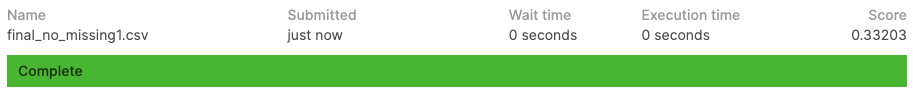

### Predictor Set 2

In [0]:
predictors=['O3','PM10','PM25','NO2_log','T2M']

In [344]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.08430288111448721
Avg. RMSE Ridge: 0.05750155164999445
Avg. RMSE Lasso: 0.08430288111448721
Avg. RMSE RF: 0.06183762023544258


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_no_missing2.csv')

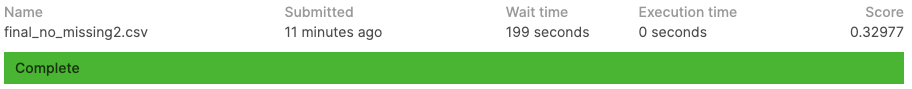

### Predictor Set 3

In [0]:
predictors=['O3','PM10','PM25_log','NO2_log','T2M']

In [346]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.08430288111448721
Avg. RMSE Ridge: 0.05746712167752003
Avg. RMSE Lasso: 0.08430288111448721
Avg. RMSE RF: 0.06183762023544258


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_no_missing3.csv')

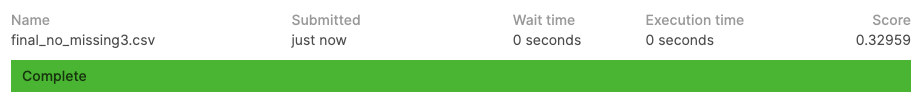

### Predictor Set 4

In [0]:
predictors=['O3','PM10_log','PM25_log','NO2_log','T2M']

In [348]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.08430288111448721
Avg. RMSE Ridge: 0.05741180968064223
Avg. RMSE Lasso: 0.08430288111448721
Avg. RMSE RF: 0.06183762023544258


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_no_missing4.csv')

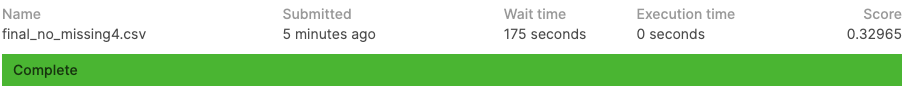

### Predictor Set 5

In [0]:
predictors=['O3','PM10_log','PM25_log','NO2_log','T2M_rolling']

In [350]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.08430288111448721
Avg. RMSE Ridge: 0.04975799609522568
Avg. RMSE Lasso: 0.08430288111448721
Avg. RMSE RF: 0.056665117085872165


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_no_missing5.csv')

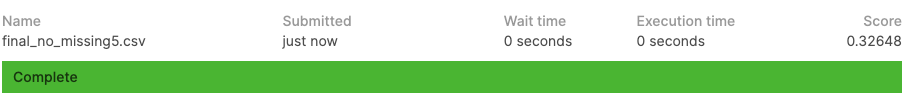

### Predictor Set 6

In [0]:
predictors=['O3','PM10_log','PM25_log','NO2_log','T2M_rolling','year','year^2','doy','doy^2']

In [352]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.08364388883801627
Avg. RMSE Ridge: 0.04685674560592255
Avg. RMSE Lasso: 0.08364388883801627
Avg. RMSE RF: 0.05507539026818298


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_no_missing6.csv')

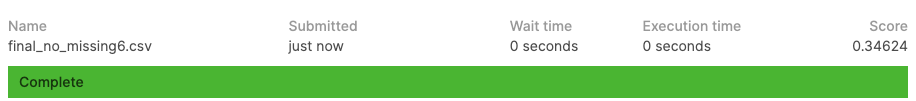

### Predictor Set 7

In [0]:
predictors=['T2M_rolling', 'year', 'year^2', 'doy', 'doy^2','E12000001', 'E12000002', 'E12000003', 'E12000004','E12000005', 'E12000006', 'E12000007', 'E12000008']

In [354]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.08364388883801627
Avg. RMSE Ridge: 0.032637071281186744
Avg. RMSE Lasso: 0.08364388883801627
Avg. RMSE RF: 0.044767233429909806


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_no_missing7.csv')

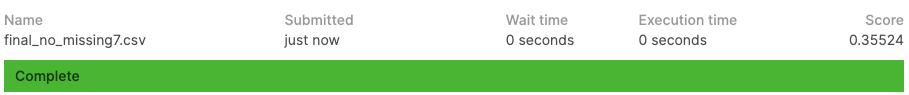

### Final Algo - mixed LR

In [0]:
a = LinearRegression()
b = LinearRegression()
c = LinearRegression()
ab = LinearRegression()

In [0]:

y0 = train_f['mortality_rate']



#modela
a_predictors = ['NO2_log', 'year', 'year^2', 'doy', 'doy^2','PM10_log']
a_X0 = train_f[a_predictors]
a.fit(a_X0, y0)



#modelb
b_predictors = [
        'T2M_rolling', 'year', 'year^2', 'doy', 'doy^2',
        'E12000001', 'E12000002', 'E12000003', 'E12000004',
        'E12000005', 'E12000006', 'E12000007', 'E12000008'
        ]
b_X0 = train_f[b_predictors]
b.fit(b_X0, y0)



#modelc
c_predictors = [
        'E12000001', 'E12000002', 'E12000003', 'E12000004',
        'E12000005', 'E12000006', 'E12000007', 'E12000008'
        ]
c_X0 = train_f[c_predictors]
c.fit(c_X0, y0)


region_effect_reduction = 0.85


# Model AB
# Produces the final solution. Combines A and "reduced B" by using their predictions as features for a linear regression.

ab_X0 = pd.DataFrame({
    'A': a.predict(a_X0),
    'reduced B': b.predict(b_X0) - (c.predict(c_X0) * region_effect_reduction)
    })

ab.fit(ab_X0, y0)

# predict

a_X1 = test_f[a_predictors]
b_X1 = test_f[b_predictors]
c_X1 = test_f[c_predictors]

ab_X1 = pd.DataFrame({'A': a.predict(a_X1),'reduced B': b.predict(b_X1) - (c.predict(c_X1) * region_effect_reduction)})

ab_y1 = ab.predict(ab_X1)



predictions = pd.DataFrame(index=test_f.index)
#predictions['mortality_rate'] =  a.predict(a_X1)
predictions['mortality_rate'] = ab_y1
predictions.to_csv('final_no_missing_final.csv')


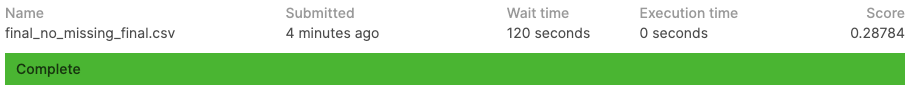

# Results
best LB socre for -(region_effect_reduction = 0.85)<br>
private score - 0.28948<br>
public score - 0.28784<br>


benchmark -<br>
private score - 0.29022<br>
public socre - 0.29259<br>

# MICE Imputation on Full Data

## Feature Engineering

In [0]:
train_f, test_f = sets(train_full_imp,test)
train_f.drop(columns='Region',inplace=True)

In [0]:
train_f, test_f = day_and_year(train_f, test_f)

In [0]:
train_f['NO2']=train_f['NO2'].apply(lambda x: f(x))
train_f['PM25']=train_f['PM25'].apply(lambda x: f(x))
train_f.isna().sum()
train_f.ffill(axis=0, inplace=True)

In [0]:
train_f, test_f = log_transform(train_f,test_f)

In [0]:
train_f, test_f = rolling(train_f,test_f)

In [360]:
train_f.shape,test_f.shape

((18142, 26), (7886, 25))

## Modelling

In [0]:
#X_train, X_test, y_train, y_test = train_test_split(train_f.drop(['mortality_rate'],axis=1), train_f['mortality_rate'], test_size=0.2)

In [0]:
RMSE= make_scorer(metrics.mean_squared_error)

In [0]:
X=train_f.drop(['mortality_rate'],axis=1)
y=train_f['mortality_rate']

### Predictor Set 1

In [0]:
predictors=['O3','PM10','PM25','NO2','T2M']

In [365]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.09128997424052981
Avg. RMSE Ridge: 0.0571595824653359
Avg. RMSE Lasso: 0.09128997424052981
Avg. RMSE RF: 0.06854168496728962


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_mice_1.csv')

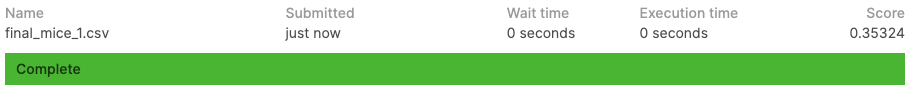

### Predictor Set 2

In [0]:
predictors=['O3','PM10','PM25','NO2_log','T2M']

In [367]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.09128997424052981
Avg. RMSE Ridge: 0.061065922730034826
Avg. RMSE Lasso: 0.09128997424052981
Avg. RMSE RF: 0.06854168496728962


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_mice_2.csv')

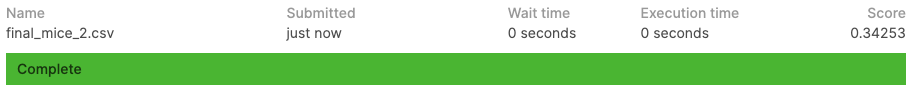

### Predictor Set 3

In [0]:
predictors=['O3','PM10','PM25_log','NO2_log','T2M']

In [369]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.09128997424052981
Avg. RMSE Ridge: 0.06107211905940293
Avg. RMSE Lasso: 0.09128997424052981
Avg. RMSE RF: 0.06854168496728962


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_mice_3.csv')

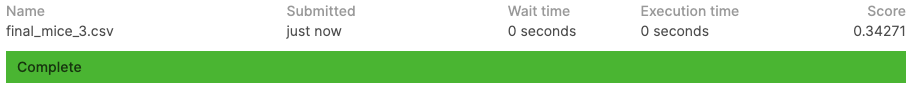

### Predictor Set 4

In [0]:
predictors=['O3','PM10_log','PM25_log','NO2_log','T2M']

In [371]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.09128997424052981
Avg. RMSE Ridge: 0.06097241783942078
Avg. RMSE Lasso: 0.09128997424052981
Avg. RMSE RF: 0.06854168496728962


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_mice_4.csv')

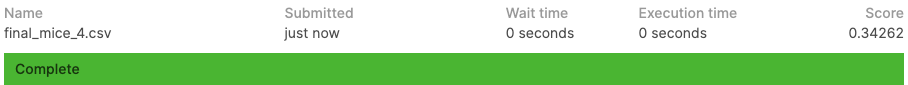

### Predictor Set 5

In [0]:
predictors=['O3','PM10_log','PM25_log','NO2_log','T2M_rolling']

In [373]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.09128997424052981
Avg. RMSE Ridge: 0.053106037876301415
Avg. RMSE Lasso: 0.09128997424052981
Avg. RMSE RF: 0.06338740423409987


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_mice_5.csv')

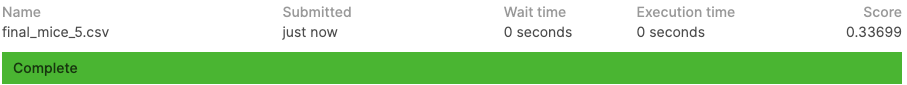

### Predictor Set 6

In [0]:
predictors=['O3','PM10_log','PM25_log','NO2_log','T2M_rolling','year','year^2','doy','doy^2']

In [375]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.08861466925672781
Avg. RMSE Ridge: 0.04767074192142795
Avg. RMSE Lasso: 0.08861466925672781
Avg. RMSE RF: 0.06284904700533618


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_mice_6.csv')

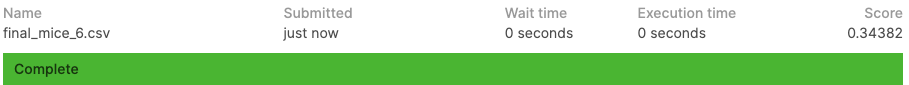

### Predictor Set 7

In [0]:
predictors=['T2M_rolling', 'year', 'year^2', 'doy', 'doy^2','E12000001', 'E12000002', 'E12000003', 'E12000004','E12000005', 'E12000006', 'E12000007', 'E12000008']

In [377]:
models(X[predictors],y)

Avg. RMSE Linear Regression: 0.08861466925672781
Avg. RMSE Ridge: 0.034019570966040205
Avg. RMSE Lasso: 0.08861466925672781
Avg. RMSE RF: 0.05143909981953948


In [0]:
reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)

reg_ridge.fit(X[predictors],y)
predictions = pd.DataFrame(index=test_f.index)
predictions['mortality_rate'] = reg_ridge.predict(test_f[predictors])
predictions.to_csv('final_mice_7.csv')

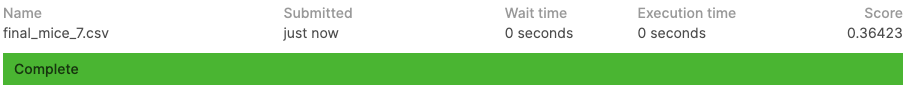

### Final Algo - mixed LR


Notation:
X0 - training predictors
y0 - training target
X1 - test predictors
y1 - predictions


In [0]:
a = LinearRegression()
b = LinearRegression()
c = LinearRegression()
ab = LinearRegression()

In [0]:

y0 = train_f['mortality_rate']



#modela
a_predictors = ['NO2_log', 'year', 'year^2', 'doy', 'doy^2','PM10_log']
a_X0 = train_f[a_predictors]
a.fit(a_X0, y0)



#modelb
b_predictors = [
        'T2M_rolling', 'year', 'year^2', 'doy', 'doy^2',
        'E12000001', 'E12000002', 'E12000003', 'E12000004',
        'E12000005', 'E12000006', 'E12000007', 'E12000008'
        ]
b_X0 = train_f[b_predictors]
b.fit(b_X0, y0)



#modelc
c_predictors = [
        'E12000001', 'E12000002', 'E12000003', 'E12000004',
        'E12000005', 'E12000006', 'E12000007', 'E12000008'
        ]
c_X0 = train_f[c_predictors]
c.fit(c_X0, y0)


region_effect_reduction = 0.85


# Model AB
# Produces the final solution. Combines A and "reduced B" by using their predictions as features for a linear regression.

ab_X0 = pd.DataFrame({
    'A': a.predict(a_X0),
    'reduced B': b.predict(b_X0) - (c.predict(c_X0) * region_effect_reduction)
    })

ab.fit(ab_X0, y0)

# predict

a_X1 = test_f[a_predictors]
b_X1 = test_f[b_predictors]
c_X1 = test_f[c_predictors]

ab_X1 = pd.DataFrame({'A': a.predict(a_X1),'reduced B': b.predict(b_X1) - (c.predict(c_X1) * region_effect_reduction)})

ab_y1 = ab.predict(ab_X1)



predictions = pd.DataFrame(index=test_f.index)
#predictions['mortality_rate'] =  a.predict(a_X1)
predictions['mortality_rate'] = ab_y1
predictions.index.name = 'Id'
predictions.to_csv('final_mice_final.csv')


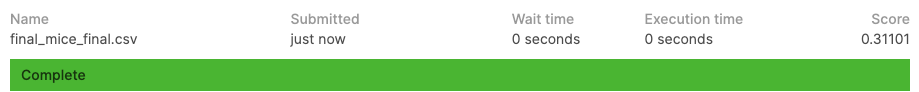

In [0]:
def models(X,y):
    reg_ridge = RandomizedSearchCV(estimator=Ridge(random_state=SEED), param_distributions=ridge_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)
    reg_lasso = RandomizedSearchCV(estimator=Lasso(random_state=SEED), param_distributions=lasso_dist, cv=inner_cv, 
                                   scoring=RMSE,random_state=SEED, n_jobs=-1)
    reg_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=SEED), param_grid=rf_dist, cv=inner_cv, 
                                   scoring=RMSE, n_jobs=-1)

    nested_score_ridge = cross_val_score(reg_ridge, X = X, y=y, cv=outer_cv,scoring=RMSE)
    nested_score_lasso = cross_val_score(reg_lasso, X = X, y=y, cv=outer_cv,scoring=RMSE)
    cv_score_linear = cross_val_score(reg_lasso, X = X, y=y, cv=outer_cv,scoring=RMSE)
    nested_score_rf = cross_val_score(reg_rf, X = X, y=y, cv=outer_cv,scoring=RMSE)
    print_scores(cv_score_linear,nested_score_ridge,nested_score_lasso,nested_score_rf)